In [1]:

import os
import gpustat
gpustat.print_gpustat()

os.environ['CUDA_VISIBLE_DEVICES']='5'
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
from autoencoder import AutoEncoder, JetDataset
import sys
import torch
import numpy as np
from collections import OrderedDict
from tqdm import tqdm
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import pickle
import argparse
import h5py
import time

from matplotlib import pyplot as plt
import matplotlib.colors as colors

imperium-sm.hep.caltech.edu  Fri Nov 22 21:59:00 2019  418.67
[0] GeForce GTX 1080 | 22'C,   0 % |  7854 /  8119 MB | qnguyen(7843M)
[1] GeForce GTX 1080 | 69'C,   0 % |  7976 /  8119 MB | 3038(7965M)
[2] GeForce GTX 1080 | 63'C,   0 % |  7976 /  8119 MB | 3038(7965M)
[3] GeForce GTX 1080 | 24'C,   0 % |  7848 /  8119 MB | qnguyen(7837M)
[4] GeForce GTX 1080 | 67'C,  50 % |  4212 /  8119 MB | 3050(4201M)
[5] GeForce GTX 1080 | 27'C,   0 % |     1 /  8119 MB |
[6] GeForce GTX 1080 | 74'C,  69 % |  4146 /  8119 MB | 3050(4135M)
[7] GeForce GTX 1080 | 65'C,  70 % |  4146 /  8119 MB | 3050(4135M)


In [2]:
data = JetDataset("step3_jets.h5")


In [3]:
plt.style.use('fivethirtyeight')

### Exploring the data

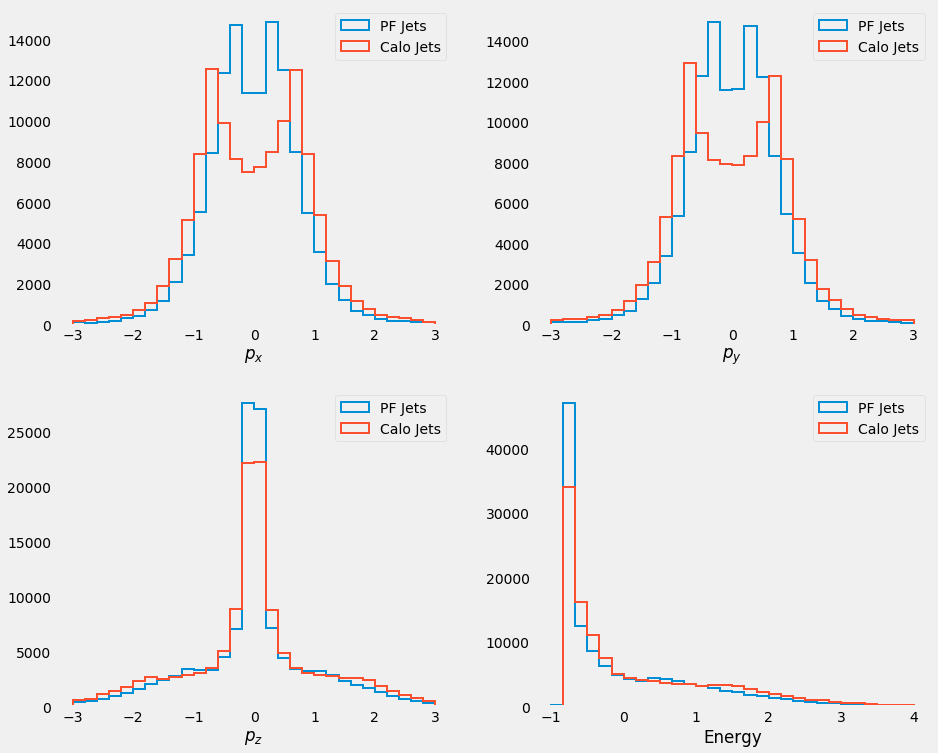

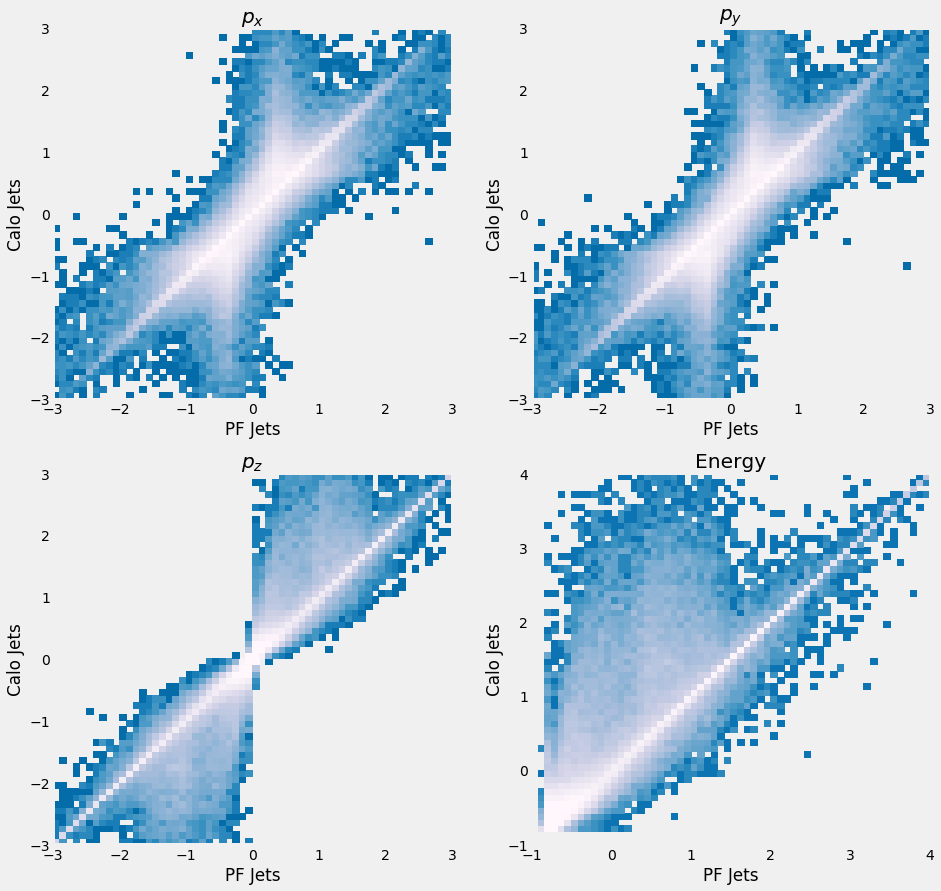

In [4]:
plot_kwargs = {"histtype": "step", 
               "linewidth": 2,
               "bins": 30}

fig, [[ax0, ax1], [ax2, ax3]] =  plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
ax0.hist(data.pfjets_px, range=(-3,3), label='PF Jets', **plot_kwargs)
ax0.hist(data.calojets_px, range=(-3,3), label='Calo Jets', **plot_kwargs)
ax0.set_xlabel('$p_x$')
ax0.grid()
ax0.legend(loc='best')

ax1.hist(data.pfjets_py, range=(-3,3), label='PF Jets', **plot_kwargs)
ax1.hist(data.calojets_py, range=(-3,3), label='Calo Jets', **plot_kwargs)
ax1.set_xlabel('$p_y$')
ax1.grid()
ax1.legend(loc='best')

ax2.hist(data.pfjets_pz, range=(-3,3), label='PF Jets', **plot_kwargs)
ax2.hist(data.calojets_pz, range=(-3,3), label='Calo Jets', **plot_kwargs)
ax2.set_xlabel('$p_z$')
ax2.grid()
ax2.legend(loc='best')

ax3.hist(data.pfjets_energy, range=(-1,4), label='PF Jets', **plot_kwargs)
ax3.hist(data.calojets_energy, range=(-1,4), label='Calo Jets', **plot_kwargs)
ax3.set_xlabel('Energy')
ax3.grid()
ax3.legend(loc='best')
fig.show()

fig, [[ax0, ax1], [ax2, ax3]] =  plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
ax0.hist2d(data.pfjets_px, data.calojets_px, bins=60, range=((-3,3), (-3,3)),
           density=True,
           norm=colors.LogNorm(vmin=1e-4, vmax=1),
           cmap='PuBu_r')
ax0.set(title='$p_x$', xlabel='PF Jets', ylabel='Calo Jets')


ax1.hist2d(data.pfjets_py, data.calojets_py, bins=60, range=((-3,3), (-3,3)),
           density=True,
           norm=colors.LogNorm(vmin=1e-4, vmax=1),
           cmap='PuBu_r')
          
ax1.set(title='$p_y$', xlabel='PF Jets', ylabel='Calo Jets')

ax2.hist2d(data.pfjets_pz, data.calojets_pz, bins=60, range=((-3,3), (-3,3)),
           density=True,
           norm=colors.LogNorm(vmin=1e-4, vmax=1),
           cmap='PuBu_r')
ax2.set(title='$p_z$', xlabel='PF Jets', ylabel='Calo Jets')

ax3.hist2d(data.pfjets_energy, data.calojets_energy, bins=60, range=((-1,4), (-1,4)),
           density=True,
           norm=colors.LogNorm(vmin=1e-4, vmax=1),
           cmap='PuBu_r')
ax3.set(title='Energy', xlabel='PF Jets', ylabel='Calo Jets')

fig.show()

### Check regression quality

In [5]:
dataloader = torch.utils.data.DataLoader(
                        data, batch_size=1000, shuffle=False,
                        )

model = AutoEncoder(features=4)
if torch.cuda.is_available():
    model = model.cuda()
model.load("test.torch")
model.eval()

prediction = []
for x, target in dataloader:
    if torch.cuda.is_available():
        x, target = x.squeeze(1).cuda(), target.squeeze(1).cuda()
    pred = model(x).cpu().detach().numpy() 
    prediction = pred if len(prediction)==0 else np.concatenate((prediction, pred), axis=0)

print(prediction.shape)
    

Loading the model's state_dict from test.torch
(124207, 4)


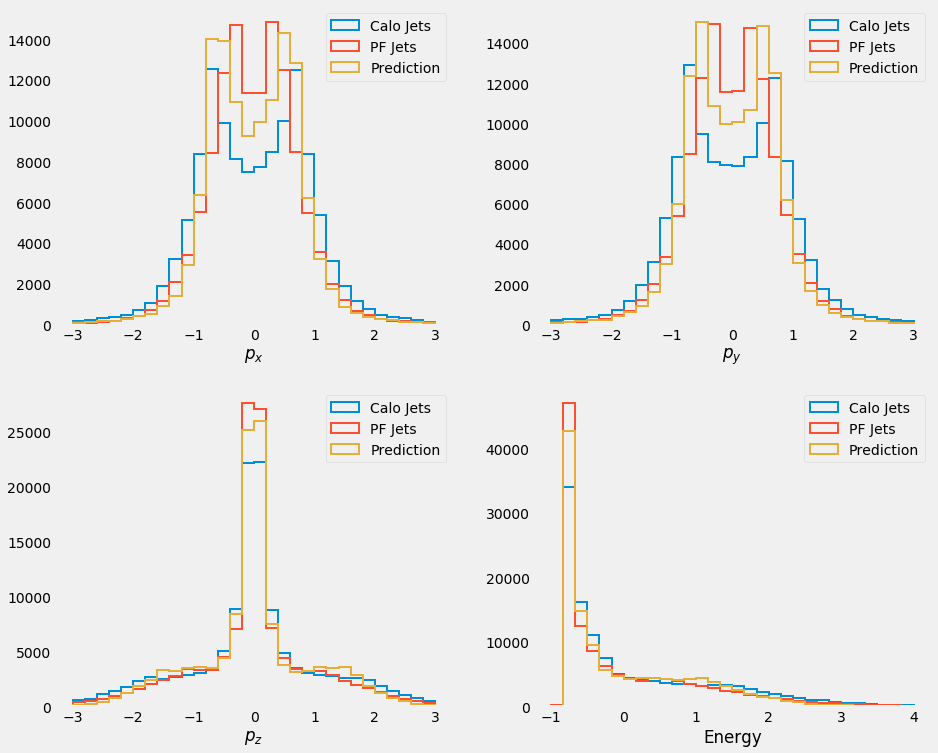

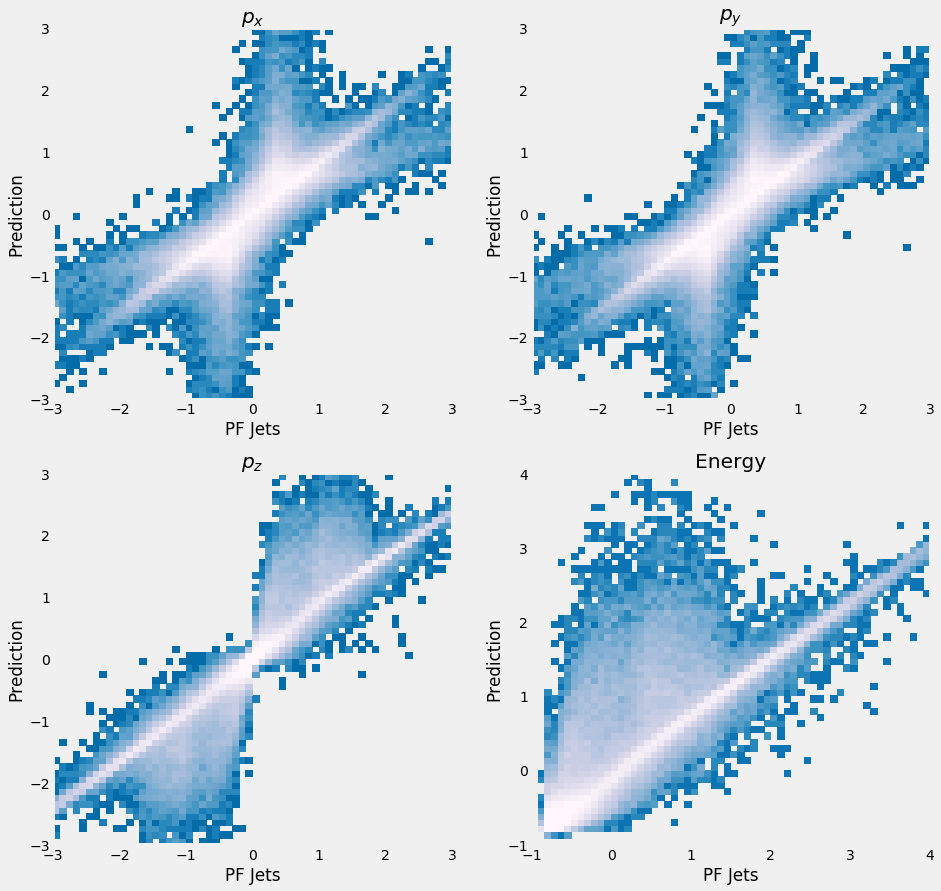

In [8]:
plot_kwargs = {"histtype": "step", 
               "linewidth": 2,
               "bins": 30}

fig, [[ax0, ax1], [ax2, ax3]] =  plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
ax0.hist(data.calojets_px, range=(-3,3), label='Calo Jets', **plot_kwargs)
ax0.hist(data.pfjets_px, range=(-3,3), label='PF Jets', **plot_kwargs)
ax0.hist(prediction[:,0].flatten(), range=(-3,3), label='Prediction', **plot_kwargs)
ax0.set_xlabel('$p_x$')
ax0.grid()
ax0.legend(loc='best')

ax1.hist(data.calojets_py, range=(-3,3), label='Calo Jets', **plot_kwargs)
ax1.hist(data.pfjets_py, range=(-3,3), label='PF Jets', **plot_kwargs)
ax1.hist(prediction[:,1].flatten(), range=(-3,3), label='Prediction', **plot_kwargs)
ax1.set_xlabel('$p_y$')
ax1.grid()
ax1.legend(loc='best')

ax2.hist(data.calojets_pz, range=(-3,3), label='Calo Jets', **plot_kwargs)
ax2.hist(data.pfjets_pz, range=(-3,3), label='PF Jets', **plot_kwargs)
ax2.hist(prediction[:,2].flatten(), range=(-3,3), label='Prediction', **plot_kwargs)
ax2.set_xlabel('$p_z$')
ax2.grid()
ax2.legend(loc='best')

ax3.hist(data.calojets_energy, range=(-1,4), label='Calo Jets', **plot_kwargs)
ax3.hist(data.pfjets_energy, range=(-1,4), label='PF Jets', **plot_kwargs)
ax3.hist(prediction[:,3].flatten(), range=(-1,4), label='Prediction', **plot_kwargs)
ax3.set_xlabel('Energy')
ax3.grid()
ax3.legend(loc='best')
fig.show()

fig, [[ax0, ax1], [ax2, ax3]] =  plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
ax0.hist2d(data.pfjets_px, prediction[:,0].flatten(), bins=60, range=((-3,3), (-3,3)),
           density=True,
           norm=colors.LogNorm(vmin=1e-4, vmax=1),
           cmap='PuBu_r')
ax0.set(title='$p_x$', xlabel='PF Jets', ylabel='Prediction')


ax1.hist2d(data.pfjets_py, prediction[:,1].flatten(), bins=60, range=((-3,3), (-3,3)),
           density=True,
           norm=colors.LogNorm(vmin=1e-4, vmax=1),
           cmap='PuBu_r')
          
ax1.set(title='$p_y$', xlabel='PF Jets', ylabel='Prediction')

ax2.hist2d(data.pfjets_pz, prediction[:,2].flatten(), bins=60, range=((-3,3), (-3,3)),
           density=True,
           norm=colors.LogNorm(vmin=1e-4, vmax=1),
           cmap='PuBu_r')
ax2.set(title='$p_z$', xlabel='PF Jets', ylabel='Prediction')

ax3.hist2d(data.pfjets_energy, prediction[:,3].flatten(), bins=60, range=((-1,4), (-1,4)),
           density=True,
           norm=colors.LogNorm(vmin=1e-4, vmax=1),
           cmap='PuBu_r')
ax3.set(title='Energy', xlabel='PF Jets', ylabel='Prediction')

fig.show()